# AI 4 StoryLines - Baseline LR

In this example, we are going to showcase how we can do sensitivity analysis using a simple linear regression model.

In [1]:
import autoroot
from sklearn.linear_model import LinearRegression, BayesianRidge, ARDRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from pathlib import Path
from dataclasses import dataclass
import xarray as xr
import pandas as pd
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from bayesevt._src.utils.io import get_list_filenames
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

We can see that there is some explained variance that is missing.
Potentially we can explain this with the regression model.

## Load Data

We have a clean analysis-ready dataset available from the previous notebook.
We will save it and revisit it later.

First, we will make sure that the models in the covariates and the QoI are the same.

In [2]:
save_dir = "/pool/usuarios/juanjohn/data/ai4storylines/analysis/"

In [3]:
# load covariates
df = pd.read_csv(Path(save_dir).joinpath("covariates.csv"), index_col=0)
# load qoi
ds = xr.open_dataset(Path(save_dir).joinpath("qoi.nc"))
# quick check
assert df.model.values.sort() == ds.model.values.sort()

In [4]:
ds

<xarray.Dataset> Size: 69kB
Dimensions:    (lon: 21, lat: 19, model: 28)
Coordinates:
  * lon        (lon) float64 168B -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
  * lat        (lat) float64 152B 26.25 28.75 31.25 33.75 ... 66.25 68.75 71.25
  * model      (model) <U16 2kB 'access_cm2' 'access_esm1_5' ... 'ukesm1_0_ll'
Data variables:
    tasmax     (model, lat, lon) float32 45kB ...
    land_mask  (model, lat, lon) int16 22kB ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

We see that we have the `4` covariates and the `19x21` grid points.

Linear Regression only works with a 1D vector. 
So we need to flatten the `u` variable.

In [5]:
ds = ds.stack(spatial=["lat", "lon"])
ds

<xarray.Dataset> Size: 78kB
Dimensions:    (model: 28, spatial: 399)
Coordinates:
  * model      (model) <U16 2kB 'access_cm2' 'access_esm1_5' ... 'ukesm1_0_ll'
  * spatial    (spatial) object 3kB MultiIndex
  * lat        (spatial) float64 3kB 26.25 26.25 26.25 ... 71.25 71.25 71.25
  * lon        (spatial) float64 3kB -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
Data variables:
    tasmax     (model, spatial) float32 45kB 3.244 2.818 2.714 ... 8.945 8.988
    land_mask  (model, spatial) int16 22kB 0 0 0 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

## Baseline Model - Linear Regression

#### Input Data

In [6]:
covariate_names = ["sst", "sm_sur", "t2m", "z500_zonal"]
qoi_names = ["tasmax"]
x = df.sort_values(by=["model"])[covariate_names].values
u = ds.sortby("model").tasmax.values

In [7]:
x.shape, u.shape

((28, 4), (28, 399))

#### Model

In [8]:
from sklearn import linear_model

reg = linear_model.Ridge(alpha=.1)
reg.fit(x, u)

Ridge(alpha=0.1)

### Post-Model Analysis

We can extract the parameters for the regression model.
The coefficient corresponds to the slope of the regression model.

In [9]:
reg.coef_.shape, reg.intercept_.shape, reg.alpha,

((399, 4), (399,), 0.1)

In [10]:
reg.coef_[0].shape

(4,)

In [11]:
ds

<xarray.Dataset> Size: 78kB
Dimensions:    (model: 28, spatial: 399)
Coordinates:
  * model      (model) <U16 2kB 'access_cm2' 'access_esm1_5' ... 'ukesm1_0_ll'
  * spatial    (spatial) object 3kB MultiIndex
  * lat        (spatial) float64 3kB 26.25 26.25 26.25 ... 71.25 71.25 71.25
  * lon        (spatial) float64 3kB -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
Data variables:
    tasmax     (model, spatial) float32 45kB 3.244 2.818 2.714 ... 8.945 8.988
    land_mask  (model, spatial) int16 22kB 0 0 0 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

Now, we will add each of these to our dataset so that we can see our

In [12]:
# sea surface height
ds["sst_weights"] = (("spatial"), reg.coef_[:, 0])
ds["sst_weights"].attrs["standard_name"] = "Weights"

# soil moisture
ds["sm_weights"] = (("spatial"), reg.coef_[:, 1])
ds["sm_weights"].attrs["standard_name"] = "Weights"

# 2m Temperature
ds["t2m_weights"] = (("spatial"), reg.coef_[:, 2])
ds["t2m_weights"].attrs["standard_name"] = "Weights"

# Geopotential @ 500
ds["z500_zonal_weights"] = (("spatial"), reg.coef_[:,3])
ds["z500_zonal_weights"].attrs["standard_name"] = "Weights"

In [13]:
ds

<xarray.Dataset> Size: 91kB
Dimensions:             (model: 28, spatial: 399)
Coordinates:
  * model               (model) <U16 2kB 'access_cm2' ... 'ukesm1_0_ll'
  * spatial             (spatial) object 3kB MultiIndex
  * lat                 (spatial) float64 3kB 26.25 26.25 26.25 ... 71.25 71.25
  * lon                 (spatial) float64 3kB -20.0 -17.5 -15.0 ... 27.5 30.0
Data variables:
    tasmax              (model, spatial) float32 45kB 3.244 2.818 ... 8.988
    land_mask           (model, spatial) int16 22kB 0 0 0 1 1 1 ... 0 0 0 0 0 0
    sst_weights         (spatial) float64 3kB 0.4088 0.3721 ... 0.2885 0.2541
    sm_weights          (spatial) float64 3kB -0.03366 0.07414 ... -0.4134
    t2m_weights         (spatial) float64 3kB 0.2812 0.3305 ... 0.9982 1.021
    z500_zonal_weights  (spatial) float64 3kB -0.01746 0.007688 ... -0.05955
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

In [14]:
ds = ds.unstack(dim="spatial")

In [15]:
ds

<xarray.Dataset> Size: 82kB
Dimensions:             (lat: 19, lon: 21, model: 28)
Coordinates:
  * lat                 (lat) float64 152B 26.25 28.75 31.25 ... 68.75 71.25
  * lon                 (lon) float64 168B -20.0 -17.5 -15.0 ... 25.0 27.5 30.0
  * model               (model) <U16 2kB 'access_cm2' ... 'ukesm1_0_ll'
Data variables:
    tasmax              (model, lat, lon) float32 45kB 3.244 2.818 ... 8.988
    land_mask           (model, lat, lon) int16 22kB 0 0 0 1 1 1 ... 0 0 0 0 0 0
    sst_weights         (lat, lon) float64 3kB 0.4088 0.3721 ... 0.2885 0.2541
    sm_weights          (lat, lon) float64 3kB -0.03366 0.07414 ... -0.4134
    t2m_weights         (lat, lon) float64 3kB 0.2812 0.3305 ... 0.9982 1.021
    z500_zonal_weights  (lat, lon) float64 3kB -0.01746 0.007688 ... -0.05955
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

## Analysis Dataset

In [16]:
vmin = -2.0
vmax = 2.0

In [17]:
from utils import plot_weights

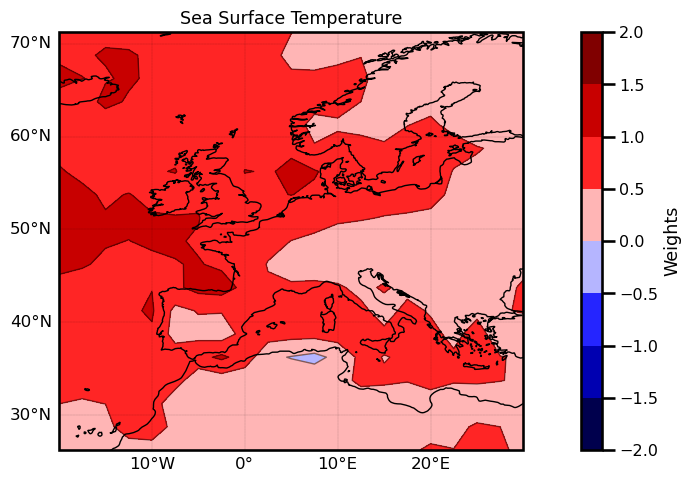

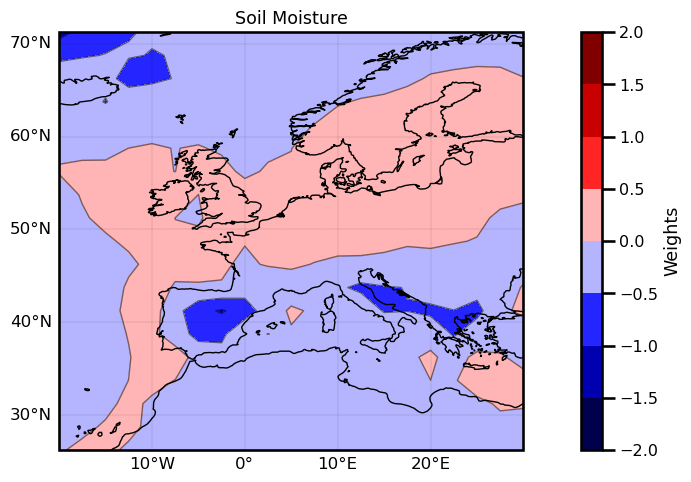

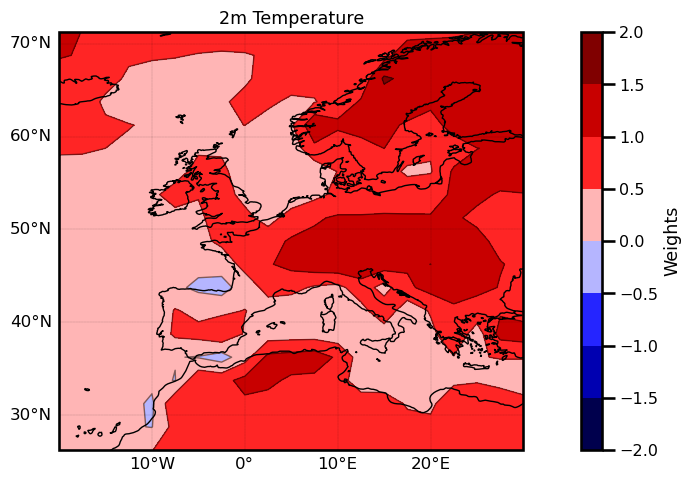

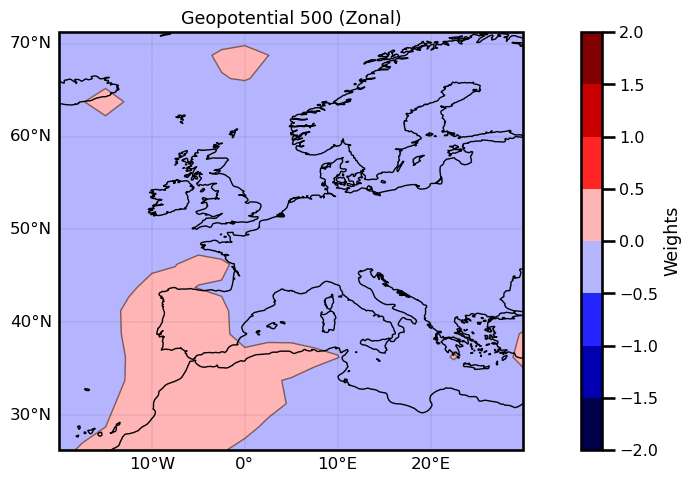

In [18]:
# plot_weights(ds.tasmax.mean(["model"]), "Sea Surface Temperature (Mean)");
plot_weights(ds.sst_weights, "Sea Surface Temperature", vmin=vmin, vmax=vmax, cmap="seismic", num_levels=8);
plot_weights(ds.sm_weights, "Soil Moisture", vmin=vmin, vmax=vmax, cmap="seismic", num_levels=8);
plot_weights(ds.t2m_weights, "2m Temperature", vmin=vmin, vmax=vmax, cmap="seismic", num_levels=8);
plot_weights(ds.z500_zonal_weights, "Geopotential 500 (Zonal)", vmin=vmin, vmax=vmax, cmap="seismic", num_levels=8);

In [19]:
results_save_dir = "/pool/usuarios/juanjohn/data/ai4storylines/results/"
ds.to_netcdf(Path(results_save_dir).joinpath("lr_sklearn.nc"), engine="netcdf4")

## Things to Do


* Standardize Input/Output Data (see [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing))
* Find the Best Parameters with Cross Validation
* Choose a Better Linear Model ([LASSO](https://scikit-learn.org/stable/modules/linear_model.html#lasso), [LARS](https://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression), [Elastic-Net](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net), [Generalized Linear Model](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models), [Quantile Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor))